# Modeling

Ce Notebook contient la deuxième phase de modélisation des conversions.

---

## Chargement des données

---

In [335]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import feature_engine
import warnings
from utils import time_class, delay_class, class_adjustment, region_agg, run_model, make_shap_waterfall_plot

In [336]:
quotes = pd.read_csv('long_quotes.csv', index_col = 0)
quotes.shape

(1215, 31)

In [337]:
# suppression des doublons de devis
quotes = quotes.drop_duplicates(subset=['long_quote_id'])
quotes.shape

(1212, 31)

---

## Création des nouveaux features

Nous avons identifé des nouvelles variables à créer:
- heure de soumission du devis
- nombre de jours avant début de contrat demandé
- le lead a-t-il plusieurs devis ? (binaire)

---

In [338]:
for col in ['submitted_at','effective_start_date']:
    quotes[col] = pd.to_datetime(quotes[col])

# plages horaire de soumission du devis
quotes['submitted_at_hour'] = quotes['submitted_at'].dt.tz_convert('Europe/Paris').dt.hour
quotes['submission_time'] =  quotes['submitted_at_hour'].map(time_class)
       
# délai souhaité en jours avant le début du contrat
quotes['delay_start_date_days'] = (quotes['effective_start_date'].dt.date  - quotes['submitted_at'].dt.date).dt.days
quotes['delay_start_class'] =  quotes['delay_start_date_days'].map(delay_class)

# nombre de devis soumis
quotes['nb_submitted_quotes'] = quotes.groupby('lead_id')['lead_id'].transform('size')

# indicateur de devis multiples
quotes['has_multiple_quotes'] = (quotes['nb_submitted_quotes'] > 1).astype(int)

quotes.shape

(1212, 37)

---

## Réduction des segmentations:

Le nombre de données étant assez limité, il est préférable de limiter les segmentations. Nous allons procéder aux regroupements suivants:

- `rbs_result`: regroupement des classes `accepted` et `needs device`
- `main_driver_age`: regroupement des classes `40-59` et `60+`
- `main_driver_licence_age`: regroupement des classes `00` et `01` puis `03-06` et `07-14`
- `main_driver_bonus`: regroupement des classes `051-063` et `064-084`
- `vehicle_age`: regroupement des classes `00` et `01-02` puis `10-14` et `15/19`
- `vehicle_class`: regroupement des classes `S-T` et `U+`
- `vehicle_group`: regroupement des classes `33-34` et `35+` et `20-26` et `27-28`
- `last_utm_source`: rare label encoding
- `product_third_party`: rare label encoding
- `product_intermediate`: rare label encoding
- `product_all_risks`: rare label encoding
- `vehicle_region`: regroupement géographique ou rare label encoding

---

In [339]:
# fonction de réduction définie dans utils.py
quotes = class_adjustment(quotes, region_agg)
quotes.shape

(1212, 38)

---

## Suppression des doublons de lead

---

In [340]:
quotes = quotes.sort_values(by = ['lead_id','has_subscribed_online', 'submitted_at'], ascending = [1, 0, 0]).drop_duplicates(subset = 'lead_id', keep ='first')
quotes.shape

(1058, 38)

---

## Suppression des variables inutiles pour le modèle

---

In [341]:
col_to_remove = ['long_quote_id', 
                 'lead_id',
                 'has_subscribed_online', 
                 'submitted_at', 
                 'effective_start_date',
                 'policy_subscribed_at', 
                 'contract_id',
                 'payment_frequency',
                 'chosen_product',                 
                 'main_driver_gender',
                 'vehicle_region',
                 'submitted_at_hour',
                 'delay_start_date_days', 
                 'nb_submitted_quotes',
]

quotes = quotes.drop(col_to_remove, axis =1)
quotes.shape

(1058, 24)

---

## Split Training and Test Set

On utilisera un split à 70-30 pour avoir un nombre suffisant de conversion dans le test set

---

In [342]:
X = quotes.drop(['has_subscribed'], axis = 1)
y = quotes['has_subscribed'].astype(int)

In [343]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((740, 23), (318, 23), (740,), (318,))

In [344]:
y_train.sum()

42

In [345]:
y_test.sum()

16

---

## Imputation


Le choix d'imputation va dépendre de différents facteurs:
    
- Le type de données (numeriques ou catégorielles)
- La proportion de données manquantes
- Est-ce que le taux de conversion est significativement différent de la moyenne sur les données manquantes ?

---

In [346]:
missing = round(X.isnull().sum().sort_values(ascending = False) / X.shape[0],3)*100
missing[missing>0]

rbs_result                   96.0
last_utm_source              81.6
chosen_formula               76.7
product_all_risks            14.9
annual_price_all_risks       14.9
product_third_party          14.5
product_intermediate         14.5
annual_price_third_party     14.5
annual_price_intermediate    14.5
provider                     14.5
vehicle_group                 1.4
vehicle_class                 1.4
dtype: float64

- `rbs_result`, `last_utm_source`, `chosen_formula`: variables catégorielles avec une part énorme de données manquantes. Le taux de conversion est plus élevé lorsque le champ est renseigné -> On va remplacer les NA par une classe `missing`.

- `product_all_risks`, `annual_price_all_risks`, `product_third_party`, `product_intermediate `, `provider`, `annual_price_third_party`, `annual_price_intermediate` : variables catégorielles avec une part raisonnable de données manquantes. Ces données sont des données de proposition commerciale et sont manquantes quand le lead n'a pas recu de proposition (`has_been_proposed_formulas` = False). Le taux de conversion est plus élevé lorsque le champ est renseigné -> On va remplacer les NA par une class `missing`.

- `vehicle_class`, `vehicle_group`: variables catégorielles avec une part très faible de données manquantes. Le taux de conversion est nul lorsque le champ est manquant -> On va remplacer les NA par une classe `missing`.


In [347]:
from feature_engine.imputation import CategoricalImputer

missing_cols = [ 'rbs_result', 'last_utm_source', 'chosen_formula', 'product_all_risks', 
                'annual_price_all_risks', 'product_third_party', 'product_intermediate', 'provider', 
                'annual_price_third_party', 'annual_price_intermediate', 'vehicle_class', 'vehicle_group']

imputation = CategoricalImputer(variables=missing_cols)
imputation.fit(X_train)

X_train = imputation.transform(X_train)
X_test = imputation.transform(X_test)

X_train.shape

(740, 23)

---

## Encoding

On va utiliser différents encoding

- Conversion des booléens en 0-1: `has_been_proposed_formulas`, `has_chosen_formula`, `has_secondary_driver`
- One hot encoding pour les variables à 2 ou 3 classes: `rbs_result`, `provider`
- Ordinal (ou Label) encoding pour les variables avec plus de 4 valeurs possible (pour ne pas trop étendre la dimension des données): `annual_price_third_party`, `annual_price_intermediate`, `annual_price_all_risks`, `chosen_formula`, `main_driver_age`, `main_driver_licence_age`, `main_driver_bonus`, `vehicle_age`,`vehicle_class`, `vehicle_group`, `submission_time`, `delay_start_class`
- Pour les variables avec plus de 7 classes, on regroupera les valeurs rares (moins de 5% d'observations) dans une classe (rare label encoding) puis on utilisera un label encoding: `last_utm_source`, `product_third_party`, `product_intermediate`, `product_all_risks`, `vehicle_region`, `vehicle_region_aggregate`

---

In [348]:
bools = X_train.select_dtypes(include=['bool']).columns.tolist()
X_train[bools] = X_train[bools].astype(int)
X_test[bools] = X_test[bools].astype(int)

In [349]:
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()
oh_encoding_var = []
ordinal_encoding_var = []
rare_encoding_var = []

for col in cat_features:
    cardinality = X_train[col].nunique()
    if cardinality < 4:
        oh_encoding_var.append(col)
    else:
        ordinal_encoding_var.append(col)
        if cardinality > 7:
            rare_encoding_var.append(col)
            
print(f'one-hot encoding variables:\n{oh_encoding_var}')
print()
print(f'ordinal encoding variables:\n{ordinal_encoding_var}')
print()
print(f'rare label encoding variables:\n{rare_encoding_var}')

one-hot encoding variables:
['rbs_result', 'provider']

ordinal encoding variables:
['last_utm_source', 'product_third_party', 'product_intermediate', 'product_all_risks', 'annual_price_third_party', 'annual_price_intermediate', 'annual_price_all_risks', 'chosen_formula', 'main_driver_age', 'main_driver_licence_age', 'main_driver_bonus', 'vehicle_age', 'vehicle_class', 'vehicle_group', 'submission_time', 'delay_start_class', 'vehicle_region_aggregate']

rare label encoding variables:
['last_utm_source', 'product_third_party', 'product_intermediate', 'product_all_risks', 'vehicle_region_aggregate']


In [350]:
from feature_engine.encoding import OneHotEncoder, RareLabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline

encoding = Pipeline([

    # one hot encoding
    ('one_hot_encoder', OneHotEncoder(variables= oh_encoding_var, drop_last=True)),
     
    # rare label encoding
    ('rare_encoder', RareLabelEncoder(tol=0.05, n_categories=4, variables=  rare_encoding_var)),
     
    # ordinale encoding
    ('ordinal_encoder', OrdinalEncoder(encoding_method='arbitrary', variables=ordinal_encoding_var))
     
])
     
X_train = encoding.fit_transform(X_train)
X_test = encoding.transform(X_test)
X_train.shape   

(740, 25)

---

## Scaling

On a assez peu de variables à forte dimension mais on peut tout de même tester un scaling pour voir si ca change quelquechose.

---

In [351]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train)

# transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# let's transform the returned NumPy arrays to dataframes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

---

## Filtre des features correlés

Lorsque des features sont trop corrélés, on n'en gardera qu'un.

---

In [352]:
from feature_engine.selection import DropCorrelatedFeatures

sel = DropCorrelatedFeatures(
    threshold=0.8,
    method='pearson',
    missing_values='ignore'
)

sel.fit(X_train_scaled)

DropCorrelatedFeatures()

In [353]:
sel.correlated_feature_sets_

[{'chosen_formula', 'has_chosen_formula'},
 {'product_all_risks', 'product_intermediate', 'product_third_party'}]

In [354]:
sel.features_to_drop_

{'chosen_formula', 'product_all_risks', 'product_intermediate'}

In [355]:
X_train = sel.transform(X_train_scaled)
X_test = sel.transform(X_test_scaled)
X_train_scaled.shape

(740, 25)

---

## Baseline Modeling

On utilisera un modèle de régression logistique comme baseline.

On mesurera la performance des modèles avec la métrique AUC pour plusieurs reasons:
- Les données sont fortement déséquilibrées donc on ne veut pas utiliser l'accuracy qui donnerait trop de poids à la classe négative.
- L'AUC mesure la qualité d'un modèle independemment du seuil de probabilité.
- C'est une mesure standard pour ce genre de problème.

---

In [356]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score

In [357]:
# Logistic Regression
logit = LogisticRegression(solver='liblinear', random_state=42, max_iter=500)

# hyperparameter space
param_grid = dict(
    penalty=['l1', 'l2'],
    C=[100, 10, 1.0, 0.1, 0.01],
    class_weight=[None,'balanced']
)

# K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# search
clf =  GridSearchCV(
    logit,
    param_grid,
    scoring='roc_auc',
    cv=kf, # k-fold
    refit=True, # refits best model to entire dataset
)

search = clf.fit(X_train_scaled, y_train)

# best hyperparameters
search.best_params_

{'C': 10, 'class_weight': None, 'penalty': 'l1'}

In [358]:
# let's get the predictions
train_preds = search.predict_proba(X_train_scaled)[:, 1]
test_preds = search.predict_proba(X_test_scaled)[:, 1]

print('Train AUC: ', roc_auc_score(y_train, train_preds))
print('Test AUC: ', roc_auc_score(y_test, test_preds))

Train AUC:  0.9028175740210125
Test AUC:  0.7481374172185431


L'AUC est de 90 sur le train set et de 75 sur le test set. Il y a un fort overfitting, ce qui n'est pas surprenant vu le faible nombre de données.

---

## Model experiments

Essayons d'autres modèles

- KNN
- Random Forest 
- BalancedRandomForest
- LightGBM (avec et sans `balance weight`)
- XGBoost (avec et sans `balance weight`)

Le dataset étant désequilibré, nous allons également essayer une méthode d'over-sampling de type SMOTE pour voir si cela permet d'augmenter la performance (nous n'avons pas assez de données pour tester l'under-sampling).

- Logistic Regression + SMOTE oversampling
- RandomForest + SMOTE oversampling
- LightGBM + SMOTE oversampling
- XGBoost + SMOTE oversampling

Note: Le paramètre de `balance_weight` permet de donner plus de poids à la classe minoritaire pour réequilibrer le dataset.

---

In [359]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
import lightgbm as lgbm
import xgboost as xgb

In [360]:
imb_weight = (len(y_train) - y_train.sum()) / y_train.sum()
imb_weight

16.61904761904762

In [361]:
model_dict = {
    
    # Logistic Regression
    'Logit': LogisticRegression( penalty ='l2', C=1, solver='liblinear', random_state=42, max_iter=100),
    
    # KNN
    'KNN': KNeighborsClassifier(n_neighbors=5),

    # Random Forest
    'RandomForest': RandomForestClassifier(
        max_depth=3,
        n_estimators=20,
        random_state=42,  
    ),
    
    # LightGBM
    'LightGBM': lgbm.LGBMClassifier(
        max_depth=3,
        n_estimators=20, 
        random_state=42,      
    ),

    # XGBoost
    'XGBoost': xgb.XGBClassifier(
        max_depth=3,
        n_estimators=20, 
        random_state=42,
    ),

    # Balanced Random Forest
    'BalancedRandomForest': BalancedRandomForestClassifier(
        max_depth=3,
        n_estimators=20,
        random_state=42,
    ),       
        
    # BalancedLightGBM
    'BalancedLightGBM': lgbm.LGBMClassifier(
        max_depth=3,
        n_estimators=20, 
        random_state=42,
        scale_pos_weight=imb_weight
    ),      
    
    # Balanced XGBoost
    'BalancedXGBoost': xgb.XGBClassifier(
        max_depth=3,
        n_estimators=20, 
        random_state=42,
        scale_pos_weight=imb_weight
    ),
}

In [362]:
results_dict = {}

# First batch of models on scaled data
for model in model_dict.keys():

    print(model)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        auc = run_model(model_dict[model], X_train_scaled, X_test_scaled, y_train, y_test)
    results_dict[model] = auc
    print()  
    

# Model with SMOTE oversampling
smote = SMOTE(
    sampling_strategy='auto',
    random_state=42,
    k_neighbors=5,
)

X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

for model in ['Logit', 'RandomForest','LightGBM','XGBoost']:
    print('SMOTE_'+ model)
    auc = run_model(model_dict[model], X_resampled, X_test_scaled, y_resampled, y_test)
    results_dict['SMOTE_' + model] = auc
    print()


Logit
Train AUC: 0.8926183653977351
Test AUC: 0.740066225165563

KNN
Train AUC: 0.95043662164006
Test AUC: 0.7160596026490066

RandomForest
Train AUC: 0.9112941738299905
Test AUC: 0.7684188741721855

LightGBM
Train AUC: 0.9624948833401555
Test AUC: 0.8003932119205298

XGBoost
Train AUC: 0.9811877473052258
Test AUC: 0.8502690397350993

BalancedRandomForest
Train AUC: 0.9182187201528176
Test AUC: 0.7016763245033113

BalancedLightGBM
Train AUC: 0.9720459817164688
Test AUC: 0.8277110927152318

BalancedXGBoost
Train AUC: 0.9883681266202756
Test AUC: 0.855546357615894

SMOTE_Logit
Train AUC: 0.9273056050442935
Test AUC: 0.7367549668874172

SMOTE_RandomForest
Train AUC: 0.9750248355924828
Test AUC: 0.7574503311258278

SMOTE_LightGBM
Train AUC: 0.9895474996100198
Test AUC: 0.7264072847682119

SMOTE_XGBoost
Train AUC: 0.9978161098841554
Test AUC: 0.7841473509933775



### Comparing results

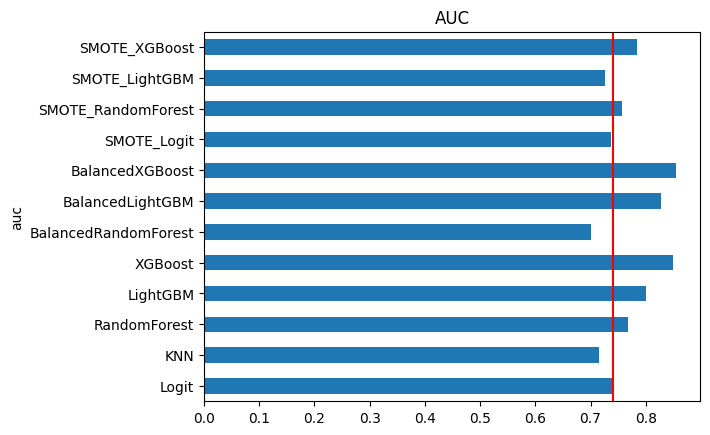

In [363]:
pd.Series(results_dict).plot.barh()
plt.title('AUC')
plt.ylabel('auc')
plt.axvline(results_dict['Logit'], color='r')
# plt.xlim([0.7, 1])
plt.show()

La meileure performance est obtenu avec le modèle *XGBoost* avec `balanced_weight` (AUC de 99 sur le train set et de 85 sur le test set). 

Il y a toujours un overfitting assez elevé qui est inhérent au problème de taille du dataset.

Utiliser un algorithme de tuning des hyperparamètres va simplement viser à renforcer la performance sur le train set qui est deja très élevée.

En règle génerale, on peut jouer avec les paramètres suivants de XGboost pour réduire l'overfitting:

- Paramètres de complexité du modèle:  `max_depth`, `min_child_weight`, `gamma` 
- Paramètre de diversification des arbres: `subsample`, `colsample_by_three`
- Learning rate

Après un certain nombre de tentatives manuelles, je n'ai pas réussi à réduire l'overfitting sans réduire nettement la performance.

On va donc plutôt se concentrer sur l'étude de la feature importance.

---

In [364]:
# Fitting du modèle avec early stopping rounds pour définir le nombre optimal d'arbres

model = xgb.XGBClassifier(
        max_depth=3,
        scale_pos_weight=imb_weight,
        random_state=42,   
)

with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        model.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], early_stopping_rounds = 20, eval_metric='auc',  verbose=False)

# predictions
train_preds = model.predict_proba(X_train_scaled)[:, 1]
test_preds = model.predict_proba(X_test_scaled)[:, 1]

print('Train AUC: ', roc_auc_score(y_train, train_preds))
print('Test AUC: ', roc_auc_score(y_test, test_preds))


Train AUC:  0.9965547823714013
Test AUC:  0.8793460264900662


---

## Feature Importance


Analysons la prédictivité des différentes variables du modèle. Pour cela, on utilisera le framework shap.

---

In [365]:
import shap
shap.initjs()

%time
samples = X_train_scaled

with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(samples, approximate=False, check_additivity=False)

CPU times: total: 0 ns
Wall time: 0 ns


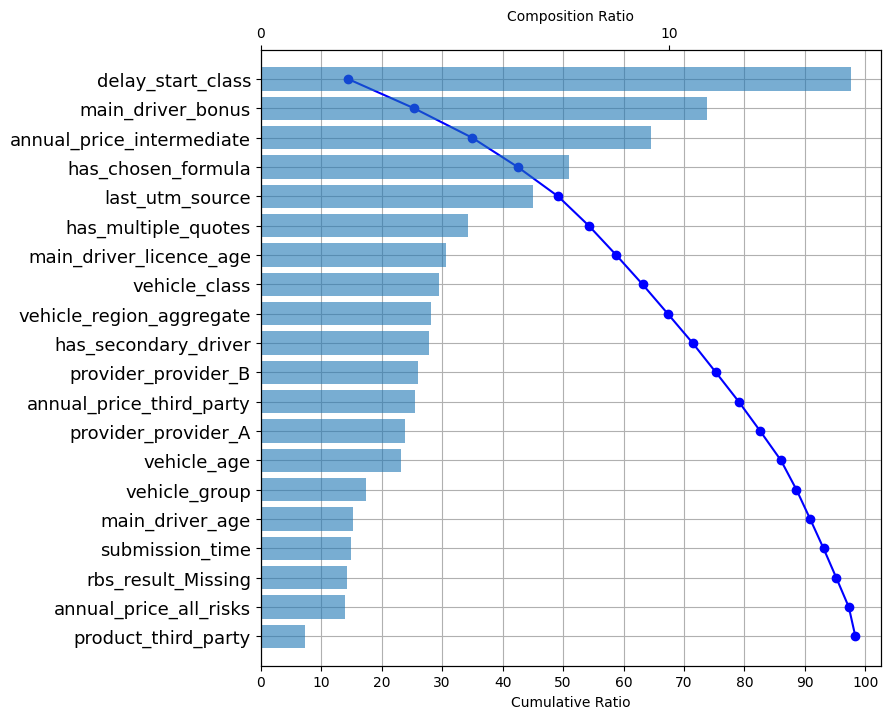

In [366]:
make_shap_waterfall_plot(shap_values, samples)

Les variables les plus prédictives sont :

- La classe de délai pour le début de contrat
- Le bonus/malus du lead
- Le prix proposé pour la formule intermédiaire
- Si le lead a choisi ou non une formule
- La source d'acquisition du lead

---

## Feature Selection

A ce stade, notre modèle a 25 variables. On peut essayer de le simplifier au moyen d'algorithme de réduction de features.

On utilisera ici un algorithme d'élimination récursive.

---

In [367]:
from feature_engine.selection import RecursiveFeatureElimination

sel = RecursiveFeatureElimination(
    variables=None, # automatically evaluate all numerical variables
    estimator = model, # the ML model
    scoring = 'roc_auc', # the metric we want to evalute
    threshold = 0.001, # the maximum performance drop allowed to remove a feature
    cv=2, # cross-validation
)

sel.fit(X_train_scaled, y_train.reset_index(drop=True))

X_train = sel.transform(X_train_scaled)
X_test = sel.transform(X_test_scaled)

sel.features_to_drop_

['has_been_proposed_formulas',
 'product_third_party',
 'product_all_risks',
 'annual_price_third_party',
 'annual_price_intermediate',
 'annual_price_all_risks',
 'chosen_formula',
 'main_driver_age',
 'vehicle_class',
 'submission_time']

In [368]:
model = xgb.XGBClassifier(
        max_depth=3,
        scale_pos_weight=imb_weight,
        random_state=42,   
)

with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds = 20, eval_metric='auc',  verbose=False)

# predictions
train_preds = model.predict_proba(X_train)[:, 1]
test_preds = model.predict_proba(X_test)[:, 1]

print('Nombre de features:',  X_train.shape[1])
print('Train AUC: ', roc_auc_score(y_train, train_preds))
print('Test AUC: ', roc_auc_score(y_test, test_preds))

Nombre de features: 15
Train AUC:  0.9956508391322144
Test AUC:  0.8856581125827815


On a pu réduire le modèle à 15 variables sans perte de performance

CPU times: total: 0 ns
Wall time: 0 ns


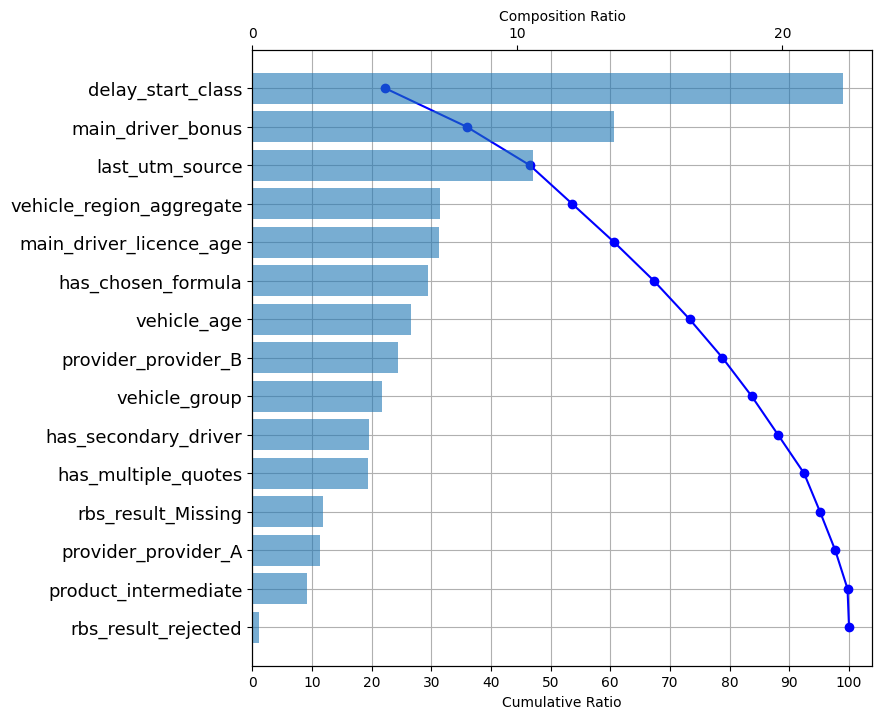

In [369]:
# shap.initjs()
%time
samples = X_train

with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(samples, approximate=False, check_additivity=False)

# Shapp waterfall plot
make_shap_waterfall_plot(shap_values, samples)

---

## ROC AUC

---

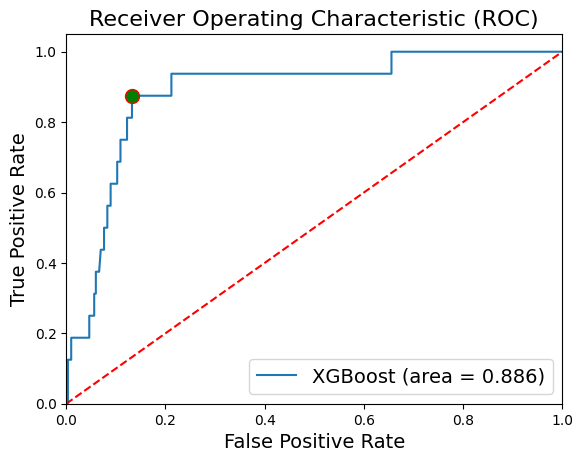

In [370]:
from sklearn.metrics import roc_curve

rf_roc_auc = roc_auc_score(y_test, test_preds)
fpr, tpr, thresholds = roc_curve(y_test, test_preds)
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (area = %0.3f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.plot(0.132, 0.875, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="green")
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
plt.legend(loc="lower right", fontsize=14)
plt.show();

In [371]:
fpr[26], tpr[26], thresholds[26]

(0.13245033112582782, 0.875, 0.26858833)

On peut voir sur la courbe le point optimal qui maximize le TPR sans trop dégrader le FPR. 

Cela correspond à un seuil de probabilité de 0.27.

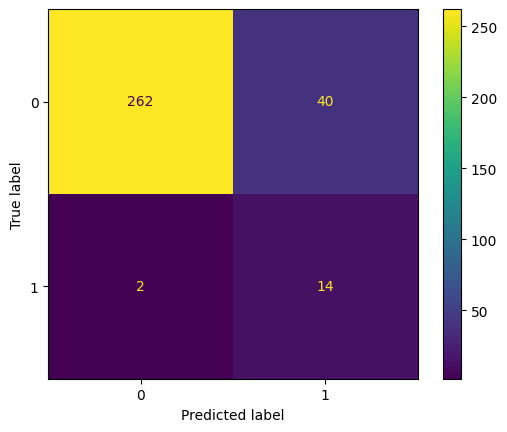

In [372]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = (model.predict_proba(X_test)[:, 1] >= 0.2685).astype(bool)

cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [373]:
from sklearn.metrics import precision_score
print('precision:', precision_score(y_test, predictions, average='binary'))
print('recall:', recall_score(y_test, predictions, average='binary'))

precision: 0.25925925925925924
recall: 0.875


Ce modèle a un bon recall mais une mauvaise précision. Il est difficile d'obtenir un modèle optimisant les deux avec si peu de données.